In [66]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [79]:
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')
print(df_train.shape,df_test.shape)

(8068, 11) (2627, 10)


In [8]:
df_train.head(10)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


In [9]:
df_test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [11]:
df_test['Segmentation'] = 'X'
df_test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,X
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,X
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,X
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,X
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,X


In [37]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_full = df_train.append(df_test)
df_full.reset_index(inplace=True)

In [68]:
df_full.shape

(10695, 13)

In [7]:
df_train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [16]:
df_full['Segmentation'].value_counts() #No imbalance issues

X    2627
D    2268
A    1972
C    1970
B    1858
Name: Segmentation, dtype: int64

## EDA

In [83]:
counts = df_test['ID'].value_counts()
counts[counts>1]

# there are 2332 IDs with two rows in the df_full. but no duplicates in train and test separately. weird? find common IDs



Series([], Name: ID, dtype: int64)

In [89]:
set1 = set(df_train['ID'])
set2 = set(df_test['ID'])
interset = set1.intersection(set2)
interlist = list(interset)
len(interlist) # interstingly 2332 are common between test and train

2332

In [91]:
# join test and train on ID

df_join = pd.merge(df_train, df_test, how='inner', left_on='ID', right_on='ID')
df_join


,ID,Gender_x,Ever_Married_x,Age_x,Graduated_x,Profession_x,Work_Experience_x,Spending_Score_x,Family_Size_x,Var_1_x,Segmentation,Gender_y,Ever_Married_y,Age_y,Graduated_y,Profession_y,Work_Experience_y,Spending_Score_y,Family_Size_y,Var_1_y
0,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A,Female,Yes,37,Yes,Engineer,NaN,Average,3.0,Cat_4
1,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,Female,Yes,69,Yes,Engineer,1.0,Low,1.0,Cat_6
2,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A,Female,Yes,41,Yes,Entertainment,NaN,High,6.0,Cat_6
3,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C,Male,Yes,58,No,Artist,0.0,Average,2.0,Cat_6
4,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C,Female,Yes,63,Yes,Artist,1.0,Average,4.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2327,465667,Male,No,23,No,Healthcare,1.0,Low,3.0,Cat_2,D,Male,No,21,No,Healthcare,0.0,Low,3.0,Cat_2
2328,463437,Male,Yes,49,Yes,Artist,1.0,Average,3.0,Cat_6,B,Male,Yes,51,Yes,Artist,0.0,Average,3.0,Cat_6
2329,459889,Male,Yes,63,Yes,Homemaker,8.0,Average,3.0,Cat_6,B,Male,Yes,59,Yes,Homemaker,9.0,Average,3.0,Cat_6
2330,465231,Male,Yes,65,No,Artist,0.0,Average,2.0,Cat_6,C,Male,Yes,67,No,Artist,1.0,Average,2.0,Cat_6


## Splitting feauture col names to label

In [44]:
feature_cols = df_full.columns.tolist()
feature_cols.remove('index')
feature_cols.remove('ID')
feature_cols.remove('train_flag')
feature_cols.remove('Segmentation')
feature_cols

label_col = 'Segmentation'

In [46]:
cat_cols = ['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1']

In [101]:
df_test.head()

,index,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,train_flag
8068,0,458989,0,1,36,1,2,0.0,2,1.0,5,X,0
8069,1,458994,1,1,37,1,5,8.0,0,4.0,5,X,0
8070,2,458996,0,1,69,0,9,0.0,2,1.0,5,X,0
8071,3,459000,1,1,59,0,4,11.0,1,2.0,5,X,0
8072,4,459001,0,0,19,0,8,NaN,2,4.0,5,X,0


### Label Encoder

In [93]:
le = LabelEncoder()
df_full['Gender'] = le.fit_transform(df_full['Gender'])
df_full['Ever_Married'] = le.fit_transform(df_full['Ever_Married'].astype(str))
df_full['Graduated'] = le.fit_transform(df_full['Graduated'].astype(str))
df_full['Profession'] = le.fit_transform(df_full['Profession'].astype(str))
df_full['Spending_Score'] = le.fit_transform(df_full['Spending_Score'].astype(str))
df_full['Var_1'] = le.fit_transform(df_full['Var_1'].astype(str))


In [94]:
df_train, df_test = df_full[df_full['train_flag']==1],df_full[df_full['train_flag']==0]

In [63]:
df_train_1, df_eval = train_test_split(df_train,test_size=0.8,shuffle=True, random_state=1010, stratify=df_train[label_col])

## Raw Model

In [39]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [64]:
lgbm = lgb.LGBMClassifier(**params)
lgbm.fit(df_train_1[feature_cols],df_train_1[label_col], early_stopping_rounds = 100,
         eval_metric='multi_error',eval_set = (df_eval[feature_cols],df_eval[label_col]),
        categorical_feature=cat_cols)

/Users/dhawal/miniconda3/envs/myenv/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Ever_Married', 'Gender', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_error: 0.718823	valid_0's multi_logloss: 1.37224
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.718823	valid_0's multi_logloss: 1.36003
[3]	valid_0's multi_error: 0.650813	valid_0's multi_logloss: 1.3505
[4]	valid_0's multi_error: 0.59969	valid_0's multi_logloss: 1.34057
[5]	valid_0's multi_error: 0.579551	valid_0's multi_logloss: 1.33048
[6]	valid_0's multi_error: 0.558482	valid_0's multi_logloss: 1.3211
[7]	valid_0's multi_error: 0.54361	valid_0's multi_logloss: 1.31312
[8]	valid_0's multi_error: 0.536174	valid_0's multi_logloss: 1.30418
[9]	valid_0's multi_error: 0.528428	valid_0's multi_logloss: 1.29691
[10]	valid_0's multi_error: 0.518978	valid_0's multi_logloss: 1.28959
[11]	valid_0's multi_error: 0.514795	valid_0's multi_logloss: 1.28282
[12]	valid_0's multi_error: 0.510922	valid_0's multi_logloss: 1.275
[13]	valid_0's multi_error: 0.509218	valid_0's multi_logloss: 1.26854
[14]	valid_0's multi_error: 0.503176	valid_

[124]	valid_0's multi_error: 0.486754	valid_0's multi_logloss: 1.0894
[125]	valid_0's multi_error: 0.4866	valid_0's multi_logloss: 1.08915
[126]	valid_0's multi_error: 0.4866	valid_0's multi_logloss: 1.08912
[127]	valid_0's multi_error: 0.487374	valid_0's multi_logloss: 1.08901
[128]	valid_0's multi_error: 0.486909	valid_0's multi_logloss: 1.08883
[129]	valid_0's multi_error: 0.487219	valid_0's multi_logloss: 1.08876
[130]	valid_0's multi_error: 0.487529	valid_0's multi_logloss: 1.08863
[131]	valid_0's multi_error: 0.487374	valid_0's multi_logloss: 1.08857
[132]	valid_0's multi_error: 0.487994	valid_0's multi_logloss: 1.08841
[133]	valid_0's multi_error: 0.487994	valid_0's multi_logloss: 1.08834
[134]	valid_0's multi_error: 0.488149	valid_0's multi_logloss: 1.08827
[135]	valid_0's multi_error: 0.488459	valid_0's multi_logloss: 1.08823
[136]	valid_0's multi_error: 0.488304	valid_0's multi_logloss: 1.08812
[137]	valid_0's multi_error: 0.488768	valid_0's multi_logloss: 1.08809
[138]	valid

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.04, max_depth=18,
               min_data_in_leaf=55, n_estimators=3000, objective='multiclass',
               random_state=42, reg_alpha=1.7, reg_lambda=1.11, subsample=0.7)

In [65]:
lgbm.best_iteration_

55

In [67]:
params['n_estimators'] = lgbm.best_iteration_

lgbm = lgb.LGBMClassifier(**params)
lgbm.fit(df_train[feature_cols],df_train[label_col],verbose=True,eval_metric='multi_error',
         categorical_feature=cat_cols)

acc_score = accuracy_score(lgbm.predict(df_train[feature_cols]),df_train[label_col])
acc_score

/Users/dhawal/miniconda3/envs/myenv/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Ever_Married', 'Gender', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.5821764997521071

In [109]:
pred = lgbm.predict(df_test[feature_cols])
submission = pd.DataFrame(pred)

dic_lists = {'ID':df_test['ID'],'Segmentation':pred}
submission = pd.DataFrame(dic_lists)
submission


,index,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation_x,train_flag,Segmentation_y
0,1,462643,0,1,38,1,2,NaN,0,3.0,3,A,1,B
1,2,466315,0,1,67,1,2,1.0,2,1.0,5,B,1,A
2,4,462669,0,1,40,1,3,NaN,1,6.0,5,A,1,B
3,5,461319,1,1,56,0,0,0.0,0,2.0,5,C,1,C
4,9,465176,0,1,55,1,0,1.0,0,4.0,5,C,1,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2327,8053,465667,1,0,23,0,5,1.0,2,3.0,1,D,1,D
2328,8054,463437,1,1,49,1,0,1.0,0,3.0,5,B,1,C
2329,8056,459889,1,1,63,1,6,8.0,0,3.0,5,B,1,C
2330,8061,465231,1,1,65,0,0,0.0,0,2.0,5,C,1,C


In [121]:

# join test and train on ID

df_join = pd.merge(submission, df_train, how='left', left_on='ID', right_on='ID')
df_join['Segmentation'] = df_join.apply(lambda x : x['Segmentation_x']  if pd.isnull(x['Segmentation_y']) else x['Segmentation_y'],axis=1)
df_join

submission_final = df_join[['ID','Segmentation']]
submission_final.to_csv('submission1.csv',index=False)

## Missing Data

<AxesSubplot:xlabel='Ever_Married', ylabel='Age'>

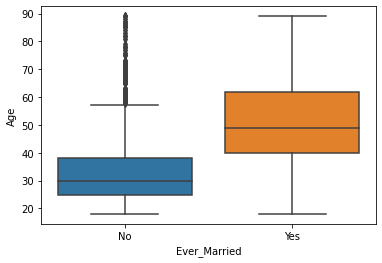

In [25]:
sns.boxplot(x=df_full['Ever_Married'],y=df_full['Age'])

<AxesSubplot:ylabel='Age'>

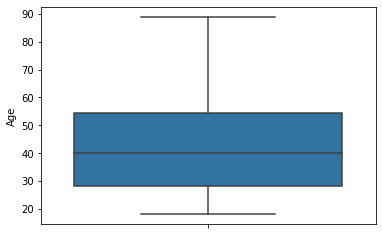

In [27]:
sns.boxplot(y=df_full[df_full['Ever_Married'].isnull()==True]['Age'])

In [20]:
df_full['Family_Size'].value_counts()

2.0    3158
1.0    1965
3.0    1952
4.0    1823
5.0     812
6.0     290
7.0     122
8.0      65
9.0      60
Name: Family_Size, dtype: int64

<AxesSubplot:xlabel='Ever_Married', ylabel='Family_Size'>

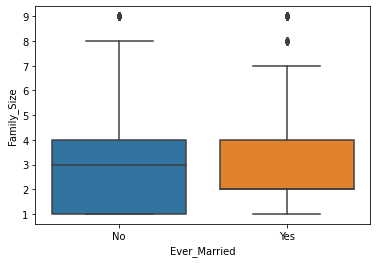

In [23]:
sns.boxplot(y=df_full['Family_Size'],x=df_full['Ever_Married'])

In [35]:
#from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

X_df_full = df_full.drop(['Segmentation','index','ID'],axis=1)
X_df_full

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6
...,...,...,...,...,...,...,...,...,...
10690,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6
10691,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6
10692,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6
10693,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4


In [36]:
imputer = KNNImputer(n_neighbors = 2)
X_df_full_imp = imputer.fit_transform(X_df_full)
X_df_full_imp

ValueError: could not convert string to float: 'Male'